In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import graphviz

In [2]:
# Load dataset dan preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255)
dataset_path = 'C:/Users/Parasetamol/Documents/Python/dataset/Jahe'  # Ganti dengan path dataset Anda

In [3]:
# Load semua gambar dan label
def load_data(dataset_path):
    images = []
    labels = []
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Found classes: {class_names}")
    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if os.path.isfile(img_path):  # Ensure it's a file
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_idx)
    return np.array(images), np.array(labels), class_names

In [4]:
images, labels, class_names = load_data(dataset_path)
print(f"Loaded {len(images)} images across {len(class_names)} classes.")

Found classes: ['Emprit', 'Gajah', 'Merah']
Loaded 480 images across 3 classes.


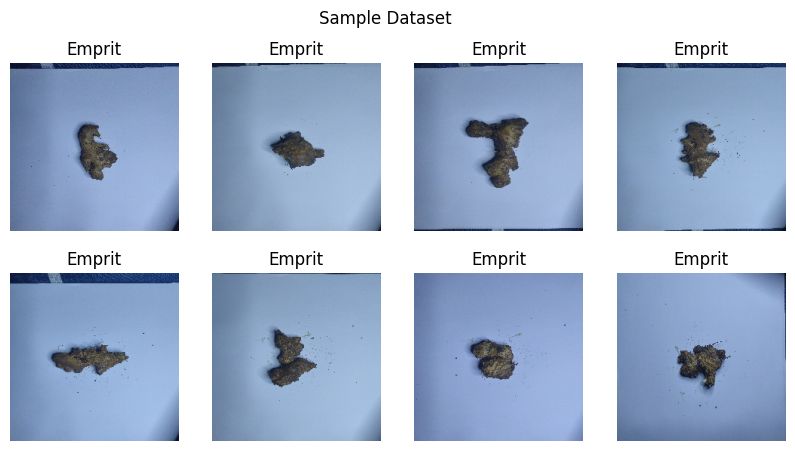

In [5]:
# Visualisasi dataset
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.suptitle("Sample Dataset")
plt.show()

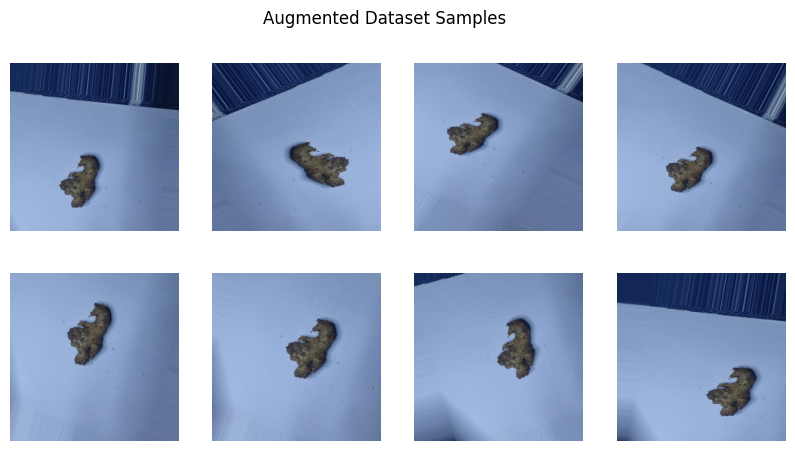

In [6]:
# Augmentasi data
augmentor = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
augmented_images = [augmentor.random_transform(images[0]) for _ in range(8)]
plt.figure(figsize=(10, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
plt.suptitle("Augmented Dataset Samples")
plt.show()

In [7]:
# Konfigurasi Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Hasil evaluasi
fold_accuracies = []
all_y_true = []
all_y_pred = []

In [9]:
# Ambil sejumlah gambar dari dataset untuk visualisasi
def get_sample_images(X, num_samples=5):
    return X[:num_samples]  # Ambil sejumlah gambar pertama dari dataset untuk visualisasi

sample_images = get_sample_images(images)  # Ambil gambar dari dataset untuk visualisasi

# Load model VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Tambahkan lapisan fully connected
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

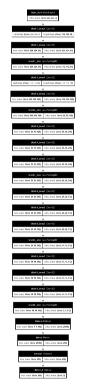

In [19]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture to a file
plot_model(model, to_file='model_vgg16.png', show_shapes=True, show_layer_names=True)

# Read the generated image and display it in the notebook
img = plt.imread('model_vgg16.png')
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [21]:
# Loop melalui setiap fold
for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels)):
    print(f"Training Fold {fold + 1}")
    
    # Split data
    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]
    
    # Preprocessing
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=len(class_names))
    
    # Training model
    model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32, verbose=1)
    
    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    
    # Evaluasi
    acc = accuracy_score(y_val, y_val_pred_classes)
    fold_accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_val_pred_classes)
    print(f"Accuracy Fold {fold + 1}: {acc}")

Training Fold 1
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9900 - loss: 0.1226 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9962 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9936 - loss: 0.2319 - val_accuracy: 1.0000 - val_loss: 3.7253e-09
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9968 - loss: 0.0510 - val_accuracy: 1.0000 - val_loss: 2.4835e-09
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 2.8436e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9894 - loss: 0.0442 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9974 -

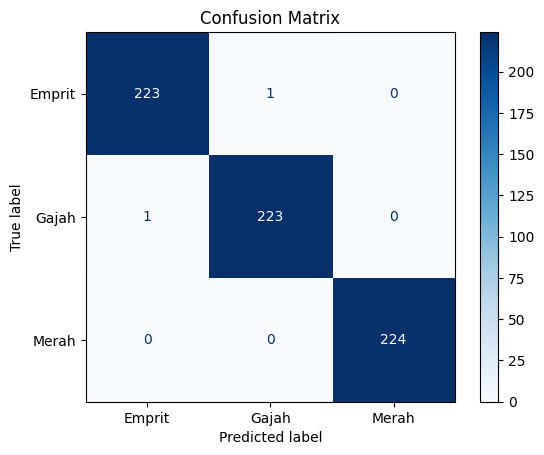

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

Cross-Validation Accuracies: [1.0, 0.9895833333333334, 1.0, 1.0, 1.0, 0.9895833333333334, 1.0]
Mean Accuracy: 0.9970238095238095


In [27]:
# Ambil model hingga layer tertentu
visual_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [29]:
# Forward pass untuk beberapa gambar sekaligus
feature_maps = visual_model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


In [31]:
# Visualisasi peta fitur untuk gambar-gambar tersebut
def plot_feature_maps(feature_maps, layer_names, cols=8):
    # Menentukan jumlah baris dan kolom untuk plotting
    num_feature_maps = feature_maps.shape[-1]
    rows = num_feature_maps // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_feature_maps):
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()

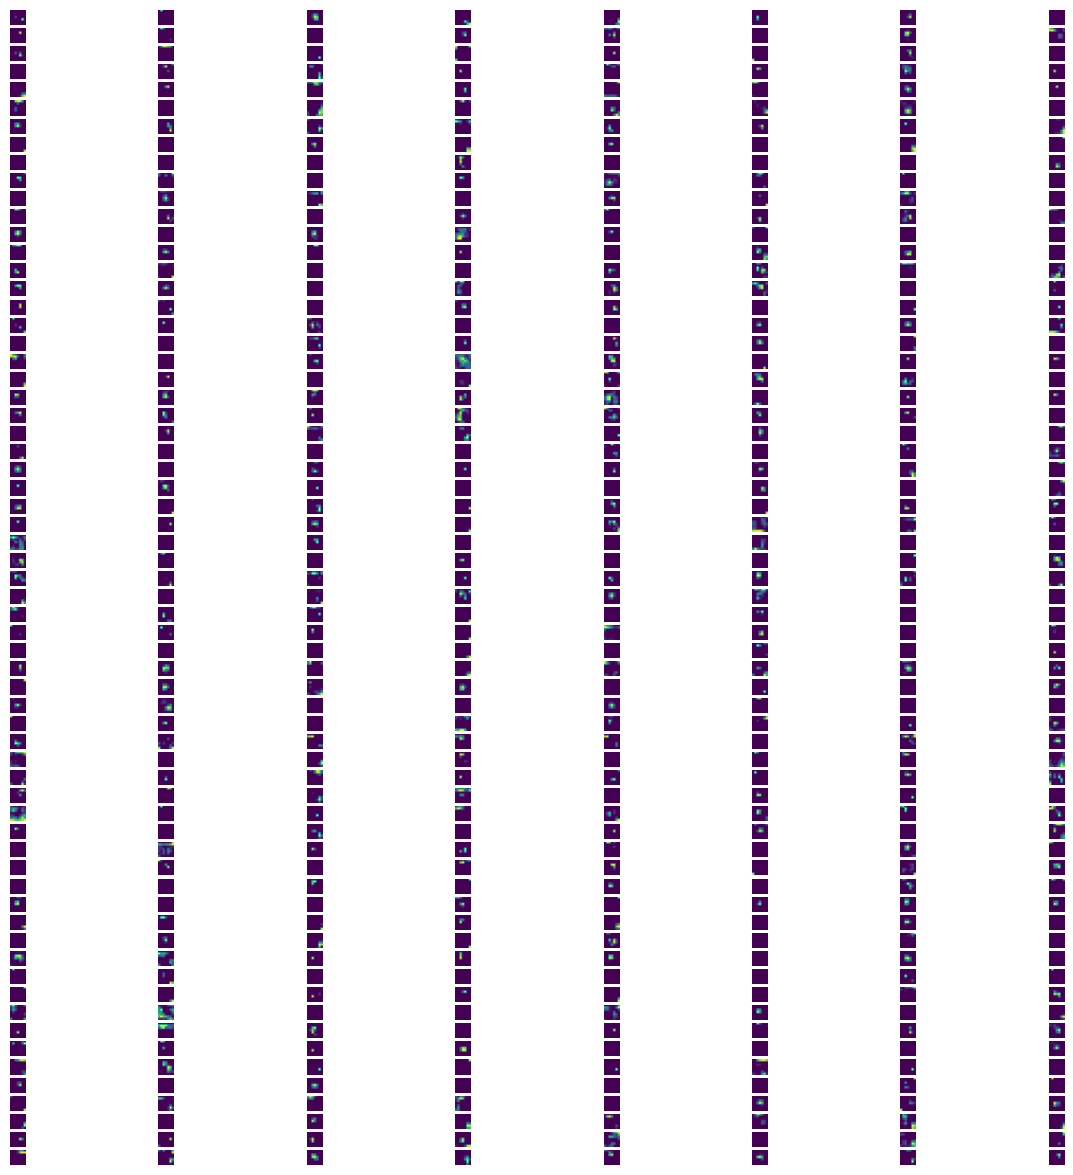

In [33]:
# Menampilkan feature maps untuk beberapa gambar pertama
plot_feature_maps(feature_maps, layer_names=['Layer 1'], cols=8)